In [1]:
#pip install git+https://github.com/marcusvolz/strava_py.git
#THIS ONE WORKS ^^^

# Strava Data Exploration

These are my attempts to make some useful plots with my own Strava data. 

First step is to explore the data in the 'activities.csv' download file.

Steps:
- Transform units
- Plot scatter

Issues with scatter:
- Lots of activities are the same time/distance so overlayed in the scatter (can see by using alpha)
- Runs and rides in same scatter distorts scale

Issues with dataframe:
- Lots of unused metrics
- Useful metrics e.g. average pace/speed missing
- Date/time in same column
- Elapsed Time and Moving Time


Solutions:

- Plot frequency graphs
- Create separate dataframes
- Calculate new metrics


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import Data

df=pd.read_csv('activities.csv')

times_seconds=df['Elapsed Time']
times_minutes=times_seconds/60
moving_times_seconds=df['Moving Time']
moving_times_minutes=moving_times_seconds/60
distance_kms=df['Distance']

dates=df['Activity Date']
#print(dates)

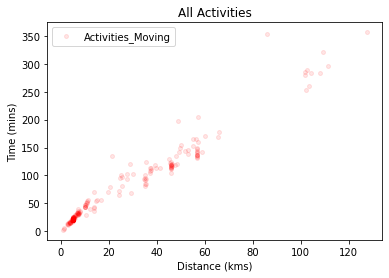

In [3]:
#a=1/len(df)

fig, ax = plt.subplots()
#ax.plot(distance_kms,times_minutes,'bo',markersize=4,alpha=0.1,label='Activities_Elapsed')
ax.plot(distance_kms,moving_times_minutes,'ro',alpha=0.1,markersize=4,label='Activities_Moving')

ax.set_title('All Activities')
ax.set_xlabel('Distance (kms)')
ax.set_ylabel('Time (mins)')
plt.legend()

In [4]:

#Separate runs and rides

runs = df.loc[df["Activity Type"] == 'Run',["Activity Date","Activity Name","Elapsed Time","Distance","Moving Time"]]   #"Activity ID",
rides = df.loc[df["Activity Type"] == 'Ride',["Activity Date","Activity Name","Elapsed Time","Distance","Moving Time"]]    #"Activity ID",

runs['Moving Time Mins'] = runs['Moving Time']/60
runs['Pace'] = runs['Moving Time Mins']/runs['Distance']

rides['Moving Time Mins'] = rides['Moving Time']/60
rides['Moving Time Hours'] = rides['Moving Time Mins']/60
rides['Speed'] = rides['Distance']/rides['Moving Time Hours']

#print(runs.head())
#print(rides.head())
#print("activities",df.shape)
#print("runs",runs.shape)
#print("rides",rides.shape)

#runs.to_csv("runs.csv")
#rides.to_csv("rides.csv")


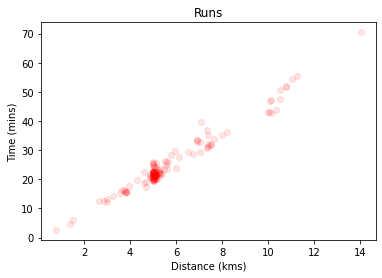

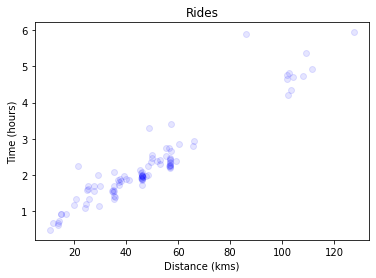

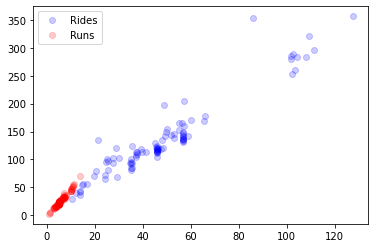

In [5]:
fig, runs_fig = plt.subplots()
runs_fig.plot(runs['Distance'],runs['Moving Time']/60,'ro',alpha=0.1)
runs_fig.set_title('Runs')
runs_fig.set_xlabel('Distance (kms)')
runs_fig.set_ylabel('Time (mins)')

fig, rides_fig = plt.subplots()
rides_fig.plot(rides['Distance'],rides['Moving Time']/(60*60),'bo',alpha=0.1)
rides_fig.set_title('Rides')
rides_fig.set_xlabel('Distance (kms)')
rides_fig.set_ylabel('Time (hours)')

fig, both_fig = plt.subplots()
both_fig.plot(rides['Distance'],rides['Moving Time']/(60),'bo',alpha=0.2,label='Rides')
both_fig.plot(runs['Distance'],runs['Moving Time']/60,'ro',alpha=0.2,label='Runs')
plt.legend()

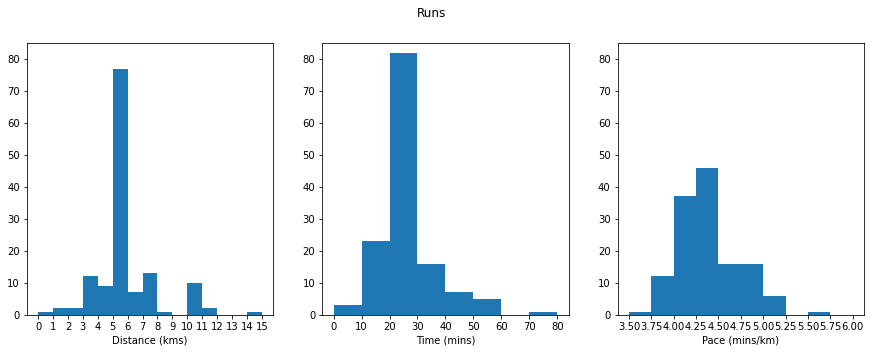

In [14]:
#print(min(runs['Distance']))
#print(max(runs['Distance']))
#print(min(runs['Moving Time Mins']))
#print(max(runs['Moving Time Mins']))
#print(min(runs['Pace']))
#print(max(runs['Pace']))

run_dist_bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
run_time_bins=[0,10,20,30,40,50,60,70,80]
run_pace_bins=[3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6]
ylimits=[0,85]
               
fig, axs = plt.subplots(1,3)

fig.suptitle("Runs")

plt.gcf().set_size_inches(15,5)

axs[0].hist(runs['Distance'],bins=run_dist_bins)
axs[0].set_xlabel('Distance (kms)')
axs[0].set(xticks=run_dist_bins)
axs[0].set(ylim=ylimits)

axs[1].hist(runs['Moving Time Mins'],bins=run_time_bins)
axs[1].set_xlabel('Time (mins)')
axs[1].set(xticks=run_time_bins)
axs[1].set(ylim=ylimits)

axs[2].hist(runs['Pace'],bins=run_pace_bins)
axs[2].set_xlabel('Pace (mins/km)')
axs[2].set(xticks=run_pace_bins)
axs[2].set(ylim=ylimits)

print()

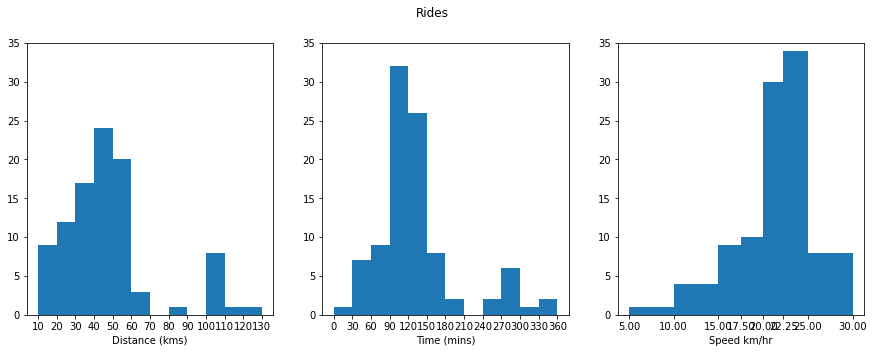

In [15]:
#print(min(rides['Distance']))
#print(max(rides['Distance']))
#print(min(rides['Moving Time Mins']))
#print(max(rides['Moving Time Mins']))
#print(min(rides['Speed']))
#print(max(rides['Speed']))

ride_dist_bins=[10,20,30,40,50,60,70,80,90,100,110,120,130]
ride_time_bins=[0,30,60,90,120,150,180,210,240,270,300,330,360]
ride_speed_bins=[5,10,15,17.5,20,22.25,25,30]
ylimits=[0,35]

fig, axs2 = plt.subplots(1,3)
fig.suptitle("Rides")

plt.gcf().set_size_inches(15,5)

axs2[0].hist(rides['Distance'],bins=ride_dist_bins)
axs2[0].set_xlabel('Distance (kms)')
axs2[0].set(xticks=ride_dist_bins)
axs2[0].set(ylim=ylimits)

axs2[1].hist(rides['Moving Time Mins'],bins=ride_time_bins)
axs2[1].set_xlabel('Time (mins)')
axs2[1].set(xticks=ride_time_bins)
axs2[1].set(ylim=ylimits)

axs2[2].hist(rides['Speed'],bins=ride_speed_bins)
axs2[2].set_xlabel('Speed km/hr')
axs2[2].set(xticks=ride_speed_bins)
axs2[2].set(ylim=ylimits)

print()